# San Diego Climate Data Exploratory Analysis

This notebook is a demonstration of some tools for exploring the weather datasets, including loading Metapack datasets, looking for missing values, and resampling. 

For a general overview of using Metapack and CKAN see:

http://kb.sandiegodata.org/notebooks/metapack-access-example/
        

In [128]:
import metapack as mp
pkg = mp.open_package('http://library.metatab.org/noaa.gov-localclimate-200808_201807-san-4.zip')
pkg

In [1]:
import metapack as mp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import missingno as msno

First, we'll get the dataset from the Data Library's data repo. This is a Metapack data package. See the [metapack access example](http://kb.sandiegodata.org/notebooks/metapack-access-example/) for more details about this format and how to get the URL for this access example. 

In [2]:
pkg = mp.open_package('http://library.metatab.org/noaa.gov-localclimate-200808_201807-san-3.csv')
pkg

Note the ``resources`` section in the package documentation. This is the datafile that we'll want to use. 

In [3]:
pkg.resource('lcd-san')

Header,Type,Description
station,string,
station_name,string,
elevation,number,
latitude,number,
longitude,number,
date,datetime,
reporttpye,string,
hourlyskyconditions,string,
hourlyvisibility,number,
hourlyprsentweathertype,string,


In [126]:
# parse_dates to ensure that the date colum is a real Timestamp() object
lcd = pkg.resource('lcd-san').read_csv(parse_dates=True)
# The date field is actually a datetime, so lets move things around. 
lcd['datetime'] = lcd.date
lcd['date'] = pd.to_datetime(lcd['datetime'].dt.date)
lcd['datetime'].min(), lcd['datetime'].max(), lcd['datetime'].max()-lcd['datetime'].min()

(Timestamp('2008-08-01 00:51:00'),
 Timestamp('2018-07-05 23:59:00'),
 Timedelta('3625 days 23:08:00'))

# Examining coverage with Missingno

The mssingno library makes it trivial to visualize missing values, which we'll need to understand which of the many columns in this data file are actually usefull. 


In [6]:
hourly_columns = [c for c in lcd.columns if c.startswith('hourly') ]
daily_columns = [c for c in lcd.columns if c.startswith('daily') ]
monthly_columns = [c for c in lcd.columns if c.startswith('monthly') ]
other_columns = [c for c in lcd.columns if c not in hourly_columns + monthly_columns + daily_columns ]

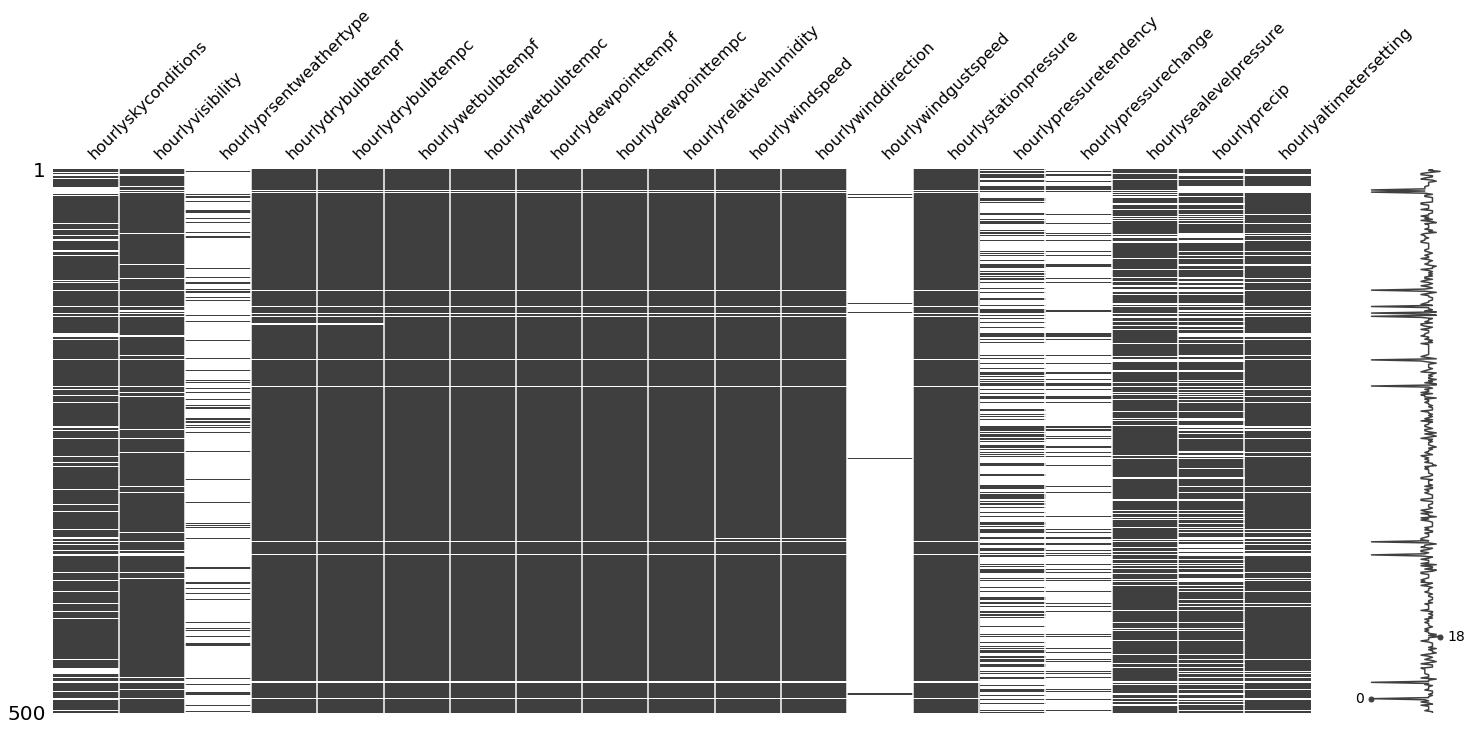

In [129]:
msno.matrix(lcd.sample(500)[hourly_columns])

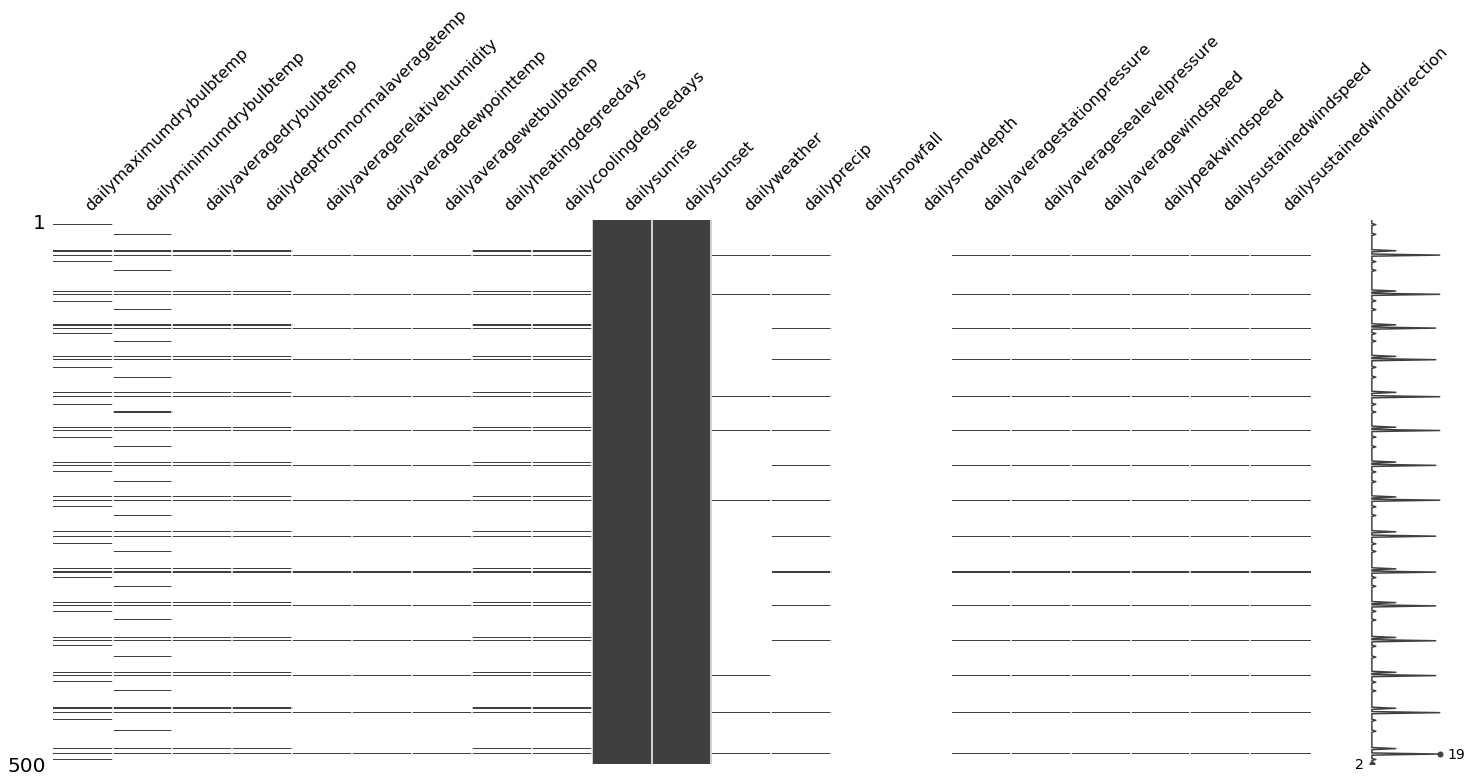

In [8]:
msno.matrix(lcd[:500][daily_columns]);

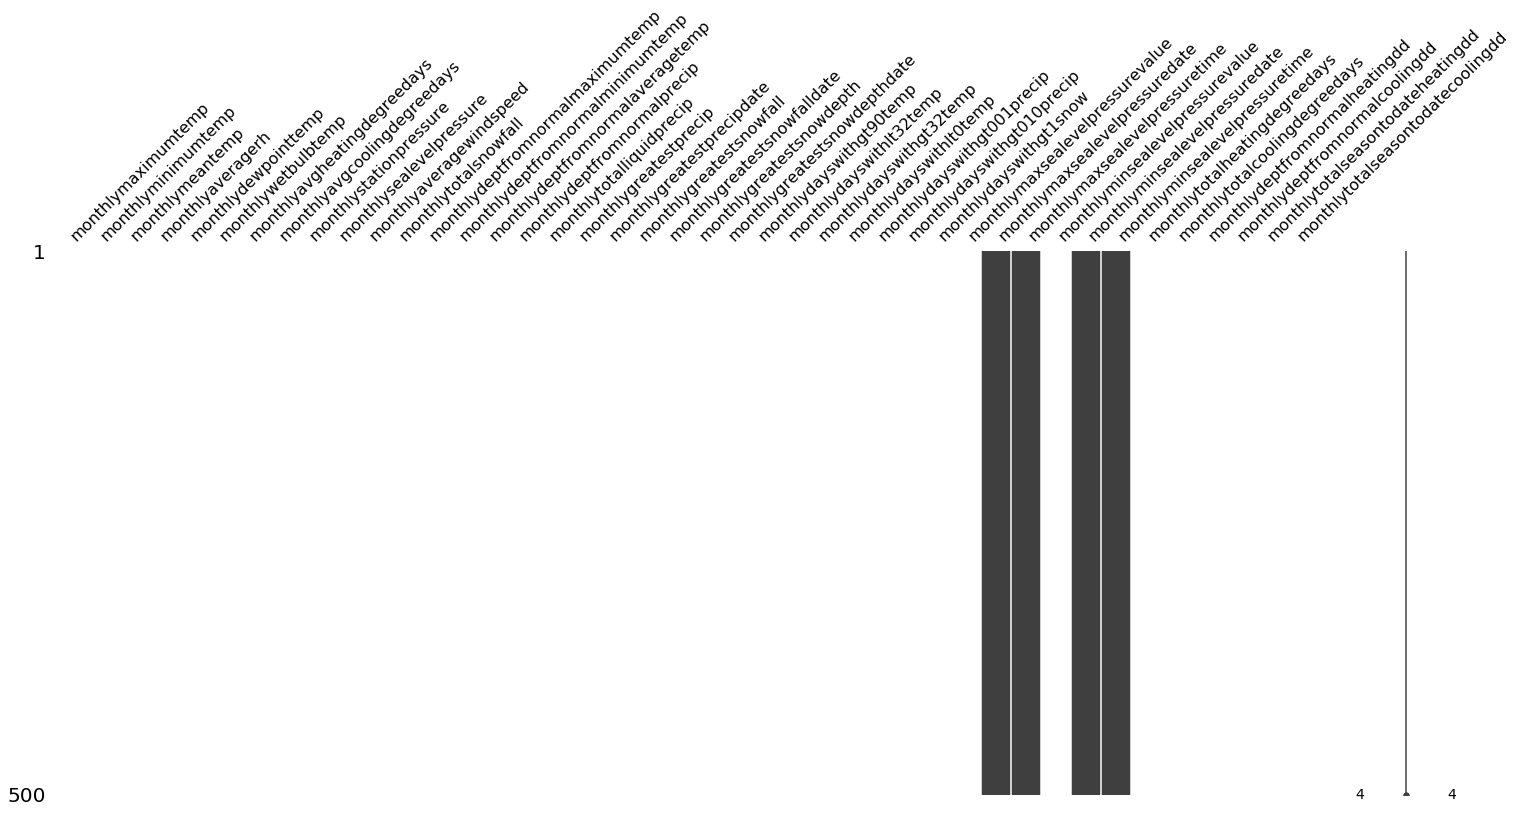

In [9]:
msno.matrix(lcd[:500][monthly_columns]);

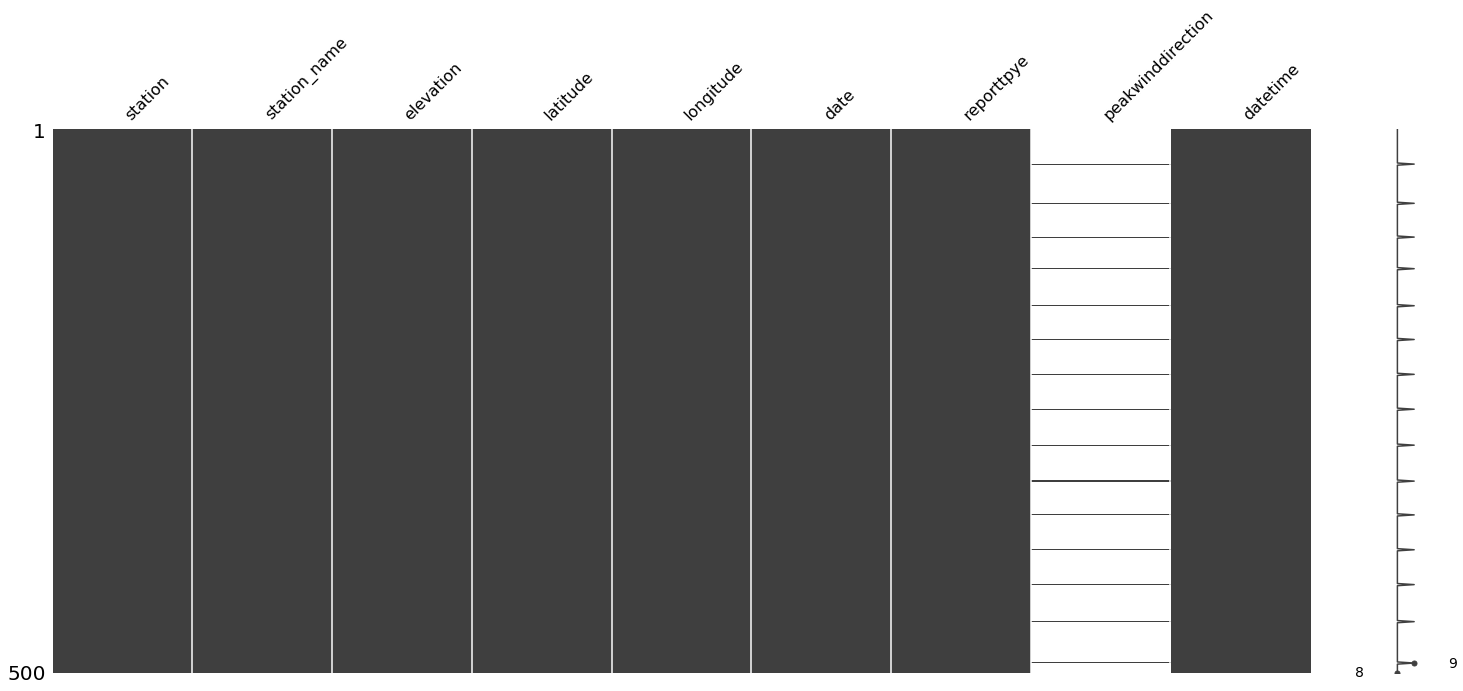

In [10]:
msno.matrix(lcd[:500][other_columns]);

In [12]:
lcd.dailyprecip.isnull().value_counts()

True     118603
False      4084
Name: dailyprecip, dtype: int64

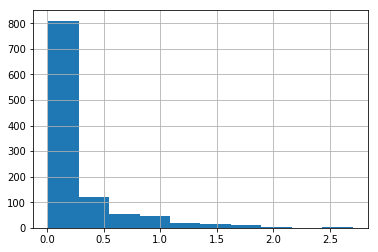

In [13]:

lcd[lcd.dailyprecip > 0].dailyprecip.hist(bins=10)

In [86]:
lcd[lcd.dailyprecip>0].reporttpye.value_counts()

SOD      368
FM-15    364
FM-12    344
FM-16      2
Name: reporttpye, dtype: int64

In [109]:
lcd[lcd.reporttpye == 'FM-15'][['datetime','dailyprecip']].fillna(0).set_index('datetime').drop_duplicates().copy().head()

,dailyprecip
datetime,
2008-08-01 00:51:00,0.00
2008-10-05 03:51:00,0.18
2008-11-05 03:51:00,0.14
2008-11-26 03:51:00,0.99
2008-11-27 03:51:00,0.10


In [106]:
dp.head()

,dailyprecip
datetime,
2008-08-01,0.00
2008-10-05,0.18
2008-11-05,0.14
2008-11-26,0.99
2008-11-27,0.10


In [110]:
dp = lcd[lcd.reporttpye == 'FM-15'][['datetime','dailyprecip']].fillna(0).set_index('datetime').drop_duplicates().copy()
dp2 = dp.resample('1d').sum()
dp.head()

,dailyprecip
datetime,
2008-08-01 00:51:00,0.00
2008-10-05 03:51:00,0.18
2008-11-05 03:51:00,0.14
2008-11-26 03:51:00,0.99
2008-11-27 03:51:00,0.10


In these two plots, the spikes should be the same height, but the first dataset has missing records for a lot of days, where the second will have a value ( usually zero ) for every day. 

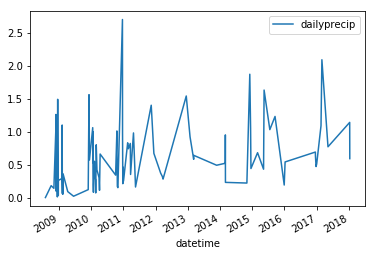

In [79]:
dp.plot()

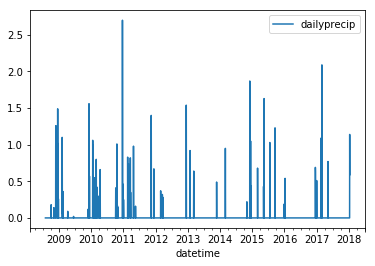

In [80]:
dp2.plot()

Although the sets are different lengths, the sum of total precipitation should be the same, as should be the number of days with nonzero precipitation. 

In [81]:
dp.dailyprecip.sum(), dp2.dailyprecip.sum()

(54.540000000000006, 54.540000000000006)

In [82]:
len(dp.dailyprecip), len(dp2)

(90, 3450)

In [83]:
len(dp[dp.dailyprecip>0]), len(dp2[dp2.dailyprecip>0]), 

(89, 89)

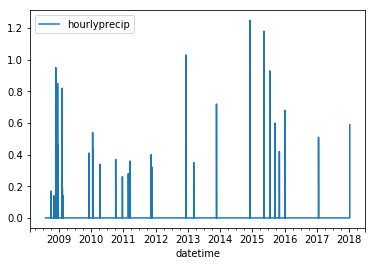

In [88]:
_ = lcd[lcd.reporttpye == 'FM-15'][['datetime','hourlyprecip']].fillna(0).set_index('datetime').drop_duplicates().copy()
hourly= _.resample('1h').sum()
prev3h = hourly.rolling(3).sum()
prev3h.plot()

In [93]:
hourly[hourly.hourlyprecip > 0].head(10)

,hourlyprecip
datetime,
2008-10-04,0.17
2008-11-04,0.14
2008-11-25,0.04
2008-11-26,0.94
2008-11-27,0.95
2008-12-15,0.47
2008-12-17,0.85
2008-12-25,0.05
2009-02-05,0.13


In [94]:
prev3h[prev3h.hourlyprecip > 0].head(10)

,hourlyprecip
datetime,
2008-10-04 00:00:00,0.17
2008-10-04 01:00:00,0.17
2008-10-04 02:00:00,0.17
2008-11-04 00:00:00,0.14
2008-11-04 01:00:00,0.14
2008-11-04 02:00:00,0.14
2008-11-25 00:00:00,0.04
2008-11-25 01:00:00,0.04
2008-11-25 02:00:00,0.04


In [101]:
dp.head()

,dailyprecip
datetime,
2008-08-01,0.00
2008-10-05,0.18
2008-11-05,0.14
2008-11-26,0.99
2008-11-27,0.10
